# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [5]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

<module 'posixpath' from '/Users/ralphblanes/anaconda/lib/python2.7/posixpath.pyc'>
cs231n/datasets/cifar-10-batches-py/data_batch_1
<module 'posixpath' from '/Users/ralphblanes/anaconda/lib/python2.7/posixpath.pyc'>
cs231n/datasets/cifar-10-batches-py/data_batch_2
<module 'posixpath' from '/Users/ralphblanes/anaconda/lib/python2.7/posixpath.pyc'>
cs231n/datasets/cifar-10-batches-py/data_batch_3
<module 'posixpath' from '/Users/ralphblanes/anaconda/lib/python2.7/posixpath.pyc'>
cs231n/datasets/cifar-10-batches-py/data_batch_4
<module 'posixpath' from '/Users/ralphblanes/anaconda/lib/python2.7/posixpath.pyc'>
cs231n/datasets/cifar-10-batches-py/data_batch_5
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [7]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.381545
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** Because there are 10 classes per image with only one correct label. Assuming an equal distribution of classes, the probablity of selecting the right one would be around 0.1 in average.


In [8]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

print("")
print "Checking Regularization"
print ""

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.775241 analytic: -0.775241, relative error: 3.379748e-08
numerical: -1.061404 analytic: -1.061404, relative error: 7.083301e-09
numerical: 0.590934 analytic: 0.590934, relative error: 1.857149e-08
numerical: -3.816107 analytic: -3.816107, relative error: 1.454363e-08
numerical: 0.375499 analytic: 0.375499, relative error: 1.270994e-07
numerical: 0.153831 analytic: 0.153831, relative error: 4.931723e-08
numerical: -1.213343 analytic: -1.213343, relative error: 4.066270e-08
numerical: -1.474443 analytic: -1.474443, relative error: 9.761814e-09
numerical: -0.928166 analytic: -0.928166, relative error: 1.027917e-09
numerical: 1.492153 analytic: 1.492153, relative error: 2.125723e-10

Checking Regularization

numerical: 2.406475 analytic: 2.406475, relative error: 1.934028e-08
numerical: -0.684613 analytic: -0.684613, relative error: 1.488233e-08
numerical: -1.298721 analytic: -1.298721, relative error: 2.787237e-08
numerical: -2.406592 analytic: -2.406592, relative error: 8.3

In [54]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.381545e+00 computed in 0.201710s
vectorized loss: 2.381545e+00 computed in 0.007535s
Loss difference: 0.000000
Gradient difference: 0.000000


In [55]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
################################################################################

for learning_rate in learning_rates:
    abs(-9)
    for regularization in regularization_strengths:
        # Keep track of the current parameters
        current_parameters = (learning_rate, regularization)
        # Create a new SVM
        current_soft = Softmax()
        # Train her
        training_the_soft = current_soft.train(X_train, y_train, learning_rate=learning_rate,reg=regularization,num_iters=2000, verbose=True)
        # Compute accuracy on training and validation sets
        training_results = current_soft.predict(X_train) # Training
        training_accuracy = np.mean(y_train == training_results)
        
        validation_results = current_soft.predict(X_val) # Validation
        validation_accuracy = np.mean(y_val == validation_results)
        
        #And add this data to the results
        results[current_parameters] = training_accuracy, validation_accuracy
        
        
        # Store best validation accuracy
        if(validation_accuracy > best_val):
            # Store the best accuracy
            best_val = validation_accuracy
            # Store the best SVM
            best_softmax = current_soft
            
        


################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 2000: loss 777.611523
iteration 100 / 2000: loss 285.334593
iteration 200 / 2000: loss 105.829037
iteration 300 / 2000: loss 40.071806
iteration 400 / 2000: loss 15.998450
iteration 500 / 2000: loss 7.206249
iteration 600 / 2000: loss 3.915383
iteration 700 / 2000: loss 2.740673
iteration 800 / 2000: loss 2.327835
iteration 900 / 2000: loss 2.164805
iteration 1000 / 2000: loss 2.124817
iteration 1100 / 2000: loss 2.057542
iteration 1200 / 2000: loss 2.046552
iteration 1300 / 2000: loss 2.082244
iteration 1400 / 2000: loss 2.156767
iteration 1500 / 2000: loss 2.142325
iteration 1600 / 2000: loss 2.097026
iteration 1700 / 2000: loss 2.078007
iteration 1800 / 2000: loss 2.095432
iteration 1900 / 2000: loss 2.128052
iteration 0 / 2000: loss 1537311.239101
iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iterati

cs231n/classifiers/softmax.py:122: RuntimeWarning: overflow encountered in exp
  exp_scores = np.exp(all_scores)
cs231n/classifiers/softmax.py:127: RuntimeWarning: invalid value encountered in divide
  softmax_scores = np.transpose(exp_scores)/exp_sum # useful when computing gradient
cs231n/classifiers/softmax.py:131: RuntimeWarning: divide by zero encountered in log
  loss_score = -1 * np.log(loss_score) #taking the logarithm


In [56]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.340000


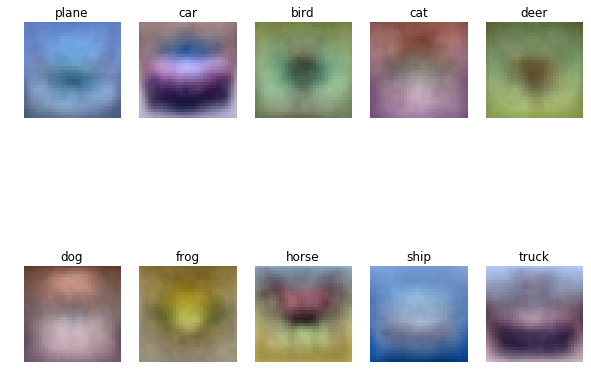

In [57]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])